# Single-cell RNA-seqs analysis using Python  
## Practicals 01: Raw reads to expression matrix

Adapted from:  
Single-cell best practices  
www.sc-best-practices.org

## 1. Raw data processing
Generate a cellxgene matrix from raw reads, using the tool `alevin-fry` to execute the final quantification of transcripts per cell.  

The commands in this section are supposed to be exectued in a command-line terminal.  Lines that begin with a hash/pound sign are comment lines, and not meant to be run.  

A script version of the commands below is also provided in (see `practicals_01.1.sh`).

### 1.1. Prepare the environment  
The conda environment with the needed tools has been created for you.  Activate it.

```
cd ~/scrnaseq_python_2023/practicals
conda activate af
```

### 1.2. Get the data  
The data for this training are already provided in `~/training_data`.  Set the path variables.

```
# The folder containing the fastq files is called toy_read_fastq.
fastq_dir="../../training_data/toy_read_fastq"

# The folder containing the human ref files is called toy_human_ref.
ref_dir="../../training_data/toy_human_ref"
```

### 1.3. Build the reference index

First, make a "splici" (spliced + intronic) extended transcriptome reference using `pyroe`.  Then, index the reference using `salmon index`.  

Usage of `pyroe make-splici` is:  
`pyroe make-splici genome_file gtf_file read_length out_dir`  
(refer to the [`pyroe` documentation](https://pyroe.readthedocs.io/en/latest/building_splici_index.html#preparing-a-spliced-intronic-transcriptome-reference))

- The `genome_file` is the reference genome sequence in fasta format.  
- The `gtf_file` is the reference annotation file in gtf format.  It should have the transcript and gene annotations.  
- The `read_length` is the number of sequencing cycles performed by the sequencer, and is the length of the biologically relevant read. Refer to the sequence provider for info on this; the 10X site also has [a page for this](https://www.10xgenomics.com/support/single-cell-gene-expression/documentation/steps/sequencing/sequencing-requirements-for-single-cell-3).  
- `out_dir` is the output directory.

Usage of `salmon index` is:  
`salmon index -t extend_txome.fa -i idx_out_dir -p num_threads`. 
- `extend_txome.fa` is the extended transcriptome fasta output of pyroe.  
- `idx_out_dir` is where you'd like the indexed reference to be written.  
- `num_threads` is how many threads you'd like to use to run indexing.

```
pyroe make-splici \
${ref_dir}/fasta/genome.fa \
${ref_dir}/genes/genes.gtf \
90 \
splici_rl90_ref

salmon index \
-t $(ls splici_rl90_ref/*\.fa) \
-i salmon_index \
-p 8
```

### 1.4. Perform mapping and quantification

#### 1.4.1. Map without quantification
Usage is:  
`salmon alevin -i index_dir -l library_type -1 reads1_files -2 reads2_files -p num_threads -o output_dir`  
(refer to the [Alevin documentation](https://salmon.readthedocs.io/en/latest/alevin.html))  

Important parameters to note include the fragment library type `-l` which different characteristics of reads1 and reads2.  More information about fragment library type can be found [here](https://salmon.readthedocs.io/en/latest/library_type.html).  Protocol should also be correctly provided.  Here, `--chromiumV3` indicates that the 10X Chromium v3 protocol was used during library preparation.  Other flags are available for other protocols, and `--custom` can be indicated for other protocols.  `--sketch` indicates that mapping will be performed but quantification will be skipped.

```
salmon alevin \
-i salmon_index \
-l ISR \
-1 ${fastq_dir}/selected_R1_reads.fastq \
-2 ${fastq_dir}/selected_R2_reads.fastq \
-p 8 \
-o salmon_alevin \
--chromiumV3 \
--sketch
```

#### 1.4.2. Cell barcode permit list generation
To perform cell barcode correction, first, generate a list of filtered barcodes that should be included in the quantification.  
Usage is:  
`alevin-fry generate-permit-list -u CB_permit_list -d expected_orientation -i index_dir -o gpl_out_dir`  
(refer to the [command documentation](https://alevin-fry.readthedocs.io/en/latest/generate_permit_list.html))  

- `-d fw` indicates that valid reads should map to the fw strand of transcripts  
- `CB_permit_list` is the file that lists all possible cell barcodes for that library preparation (provided by manufacturer).  Other protocols do not have this, in which case another way of generating a barcode permit list should be used, e.g., `--knee-distance`.  

```
alevin-fry generate-permit-list \
-u "../../training_data/3M-february-2018.txt" \
-d fw \
-i salmon_alevin \
-o alevin_fry_gpl
```

Sample output of generating permit list:

```
2023-08-11 10:55:18 INFO number of unfiltered bcs read = 6,794,880
2023-08-11 10:55:18 INFO paired : false, ref_count : 337, num_chunks : 7
2023-08-11 10:55:18 INFO read 2 file-level tags
2023-08-11 10:55:18 INFO read 2 read-level tags
2023-08-11 10:55:18 INFO read 1 alignemnt-level tags
2023-08-11 10:55:18 INFO File-level tag values FileTags { bclen: 16, umilen: 12 }
2023-08-11 10:55:18 INFO observed 33,206 reads (18,985 orientation consistent) in 7 chunks --- max ambiguity read occurs in 24 refs
2023-08-11 10:55:18 INFO minimum num reads for barcode pass = 10
2023-08-11 10:55:18 INFO num_passing = 139
2023-08-11 10:55:18 INFO found 139 cells with non-trivial number of reads by exact barcode match
2023-08-11 10:55:18 INFO There were 893 distinct unmatched barcodes, and 151 that can be recovered
2023-08-11 10:55:18 INFO Matching unmatched barcodes to retained barcodes took 175.209µs
2023-08-11 10:55:18 INFO Of the unmatched barcodes
============
2023-08-11 10:55:18 INFO 	195 had exactly 1 single-edit neighbor in the retained list
2023-08-11 10:55:18 INFO 	49 had >1 single-edit neighbor in the retained list
2023-08-11 10:55:18 INFO 	1,586 had no neighbor in the retained list
2023-08-11 10:55:18 INFO total number of distinct corrected barcodes : 151
```

#### 1.4.3.  Cell barcode filtering  
The second step of cell barcode correction is using the generated barcode permit list to filter the mapping information.  
Usage is:  
`alevin-fry collate -i gpl_out_dir -r alevin_map_dir -t num_threads`

```
alevin-fry collate \
-i alevin_fry_gpl \
-r salmon_alevin \
-t 8
```

Sample output of filter mapping:  

```
2023-08-11 10:56:58 INFO filter_type = Unfiltered
2023-08-11 10:56:58 INFO collated rad file will not be compressed
2023-08-11 10:56:58 INFO paired : false, ref_count : 337, num_chunks : 7, expected_ori : Forward
2023-08-11 10:56:58 INFO read 2 file-level tags
2023-08-11 10:56:58 INFO read 2 read-level tags
2023-08-11 10:56:58 INFO read 1 alignemnt-level tags
2023-08-11 10:56:58 INFO File-level tag values FileTags { bclen: 16, umilen: 12 }
2023-08-11 10:56:58 INFO deserialized correction map of length : 290
2023-08-11 10:56:58 INFO Generated 1 temporary buckets.
  [00:00:00] [╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢]       7/7       partitioned records into temporary files.                                                                                                       [00:00:00] [╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢]       1/1       gathered all temp files.                                                                                                                      2023-08-11 10:56:58 INFO writing num output chunks (139) to header
2023-08-11 10:56:58 INFO expected number of output chunks 139
2023-08-11 10:56:58 INFO finished collating input rad file "salmon_alevin/map.rad".
```

#### 1.4.4. UMI resolution + quantification  
Usage: 
`alevin-fry quant -r resolution -m txp_to_gene_mapping -i gpl_out_dir -o quant_out_dir -t num_threads`  
(refer to [documentation](https://alevin-fry.readthedocs.io/en/latest/quant.html) for more information on the parameters)

- `-r` refers to the method used for UMI resolution  
- `-m` is the transcript-to-gene map file (the file that ends with `3col.tsv` in the splici generation output folder), and contains target or transcript ID, gene feature ID, splice status.  

```
alevin-fry quant \
-r cr-like \
-m $(ls splici_rl90_ref/*3col.tsv) \
-i alevin_fry_gpl \
-o alevin_fry_quant \
-t 8
```

Sample stdout of above command:  

```
2023-08-11 10:57:48 INFO quantifying from uncompressed, collated RAD file File { fd: 4, path: "/Users/irisyu/Library/CloudStorage/GoogleDrive-irisyu@ebi.ac.uk/My Drive/Notes/Notebooks/trainings/scrnaseq_python_2023/af_xmpl_run/alevin_fry_gpl/map.collated.rad", read: true, write: false }
2023-08-11 10:57:48 INFO paired : false, ref_count : 337, num_chunks : 139
2023-08-11 10:57:48 INFO tg-map contained 20 genes mapping to 337 transcripts.
2023-08-11 10:57:48 INFO read 2 file-level tags
2023-08-11 10:57:48 INFO read 2 read-level tags
2023-08-11 10:57:48 INFO read 1 alignemnt-level tags
2023-08-11 10:57:48 INFO File-level tag values FileTags { bclen: 16, umilen: 12 }
  [00:00:00] [╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢╢]     139/139     finished quantifying 139 cells.                                                                                                               2023-08-11 10:57:48 INFO processed 17,350 total read records
```

Inspect the quantification result files in `alevin_fry_quant/alevin`.  
```
% tail -3 alevin_fry_quant/alevin/quants_mat.mtx  
138 58 1
139 9 1
139 37 1
% tail -3 alevin_fry_quant/alevin/quants_mat_rows.txt 
TTCGATTTCCGCTTAC
TGCTCGTGTTCGAAGG
ACTGTGAAGAAATTGC
% tail -3 alevin_fry_quant/alevin/quants_mat_cols.txt 
ENSG00000120705-A
ENSG00000198961-A
ENSG00000245526-A
```

__Optional for this demo__  
You may load your alevin-fry results as an annData object with below command.  To try below, your notebook must be open in an env with `pyroe`.  
```
conda activate pyroe
```
And then uncomment all the commands (they have been commented out in the cells below so you don't accidentally run them).

In [ ]:
# import pyroe

# quant_dir = 'alevin_fry_quant'
# adata_sa = pyroe.load_fry(quant_dir)

Or, to include unspliced transcript variants in the count:

In [ ]:
# import pyroe

# quant_dir = 'alevin_fry_quant'
# adata_usa = pyroe.load_fry(quant_dir, output_format={'X' : ['U','S','A']})

More information about `pyroe.load_fry()` can be found [here](https://pypi.org/project/pyroe/0.7.1/).

### Optional: Simpleaf method  
The pipeline above can be run with fewer commands using the wrapper `simpleaf`.  However, it offers less flexibility.  Below summarizes the set of commands.  To run below in the command line, `simpleaf` must be installed. This wrapper is also installed in the conda env `af` that we provide in the VM.

```
conda activate af

mkdir alevin_fry_home & export ALEVIN_FRY_HOME='alevin_fry_home'

simpleaf set-paths

simpleaf index \
-o simpleaf_index \
-f "../../training_data/toy_human_ref/fasta/genome.fa" \
-g "../../training_data/toy_human_ref/genes/genes.gtf" \
-r 90 \
-t 8

simpleaf quant \
-c 10xv3 -t 8 \
-1 $reads1 -2 $reads2 \
-i simpleaf_index/index \
-u -r cr-like \
-m simpleaf_index/index/t2g_3col.tsv \
-o simpleaf_quant
```

### Optional: Remove empty drops (Atlas method)  
=====COME BACK HERE=====

#### Convert from mtx to 10x  
Below is a script that also uses pyroe, with USA mode  (use conda env `pyroe` or `parse_alevin_fry` in codon to run).
In codon, the script is copied to `/homes/irisyu/training/scrnaseq_python_2023/bin` (add to PATH).

export PATH=/homes/irisyu/training/scrnaseq_python_2023/bin:$PATH

```
(pyroe) % alevinFryMtxTo10x.py alevin_fry_quant alevin_fry_parsed single_cell 
USA mode: True
Using pre-defined output format: scrna
Will populate output field X with sum of counts frorm ['S', 'A'].
Will combine ['U'] into output layer unspliced.
```

#### Remove empty drops  

Below, use conda env with `bioconductor-dropletutils` and `dropletutils-scripts`.  In codon, the scripts `/nfs/production/irene/ma/fg_atlas_sc/nextflow_scxa_test/envs/dropletutils-a2f6101409ff7f11d8d66c59f1f32ead/bin/dropletutils-*.R` are copied to `/homes/irisyu/training/scrnaseq_python_2023/bin` (add to PATH).  The scripts should also be in the dropletutils-scripts env bin.  

```
(dropletutils)[fg_atlas@hl-codon-101-03 af_xmpl_run]$ dropletutils-read-10x-counts.R -s alevin_fry_parsed -c TRUE -o alevin_fry_parsed/matrix.rds
...
# Object summary
class: SingleCellExperiment
dim: 20 139
metadata(0):
assays(1): counts
rownames(20): ENSG00000131507 ENSG00000131508 ... ENSG00000198961                                        
  ENSG00000245526
rowData names(2): ID Symbol
colnames(139): ACTTTCAAGATCACCT GTGGAGACAATTAGGA ... TGCTCGTGTTCGAAGG                                    
  ACTGTGAAGAAATTGC
colData names(2): Sample Barcode
reducedDimNames(0):
spikeNames(0):

# Metadata sample
DataFrame with 6 rows and 2 columns
                            Sample          Barcode
                       <character>      <character>
ACTTTCAAGATCACCT alevin_fry_parsed ACTTTCAAGATCACCT
GTGGAGACAATTAGGA alevin_fry_parsed GTGGAGACAATTAGGA
GTGTGGCGTAGTGTGG alevin_fry_parsed GTGTGGCGTAGTGTGG
GTGGAGATCTTCCTAA alevin_fry_parsed GTGGAGATCTTCCTAA
TTACAGGAGCTCTGTA alevin_fry_parsed TTACAGGAGCTCTGTA
AGACACTTCGACGCGT alevin_fry_parsed AGACACTTCGACGCGT


(dropletutils)[fg_atlas@hl-codon-101-03 af_xmpl_run]$ dropletutils-empty-drops.R -i alevin_fry_parsed/matrix.rds --lower 5 --niters 1000 --filter-empty TRUE --filter-fdr 0.01 -o empty_drops/nonempty.rds -t empty_drops/nonempty.txt                                               ...
At an FDR of 0.01, estimate that 34 barcodes have cells.                                                 
Will filter to 34 barcodes.

Parameter values:
             value
lower            5
niters        1000
test_ambient FALSE
filter_empty  TRUE
filter_fdr    0.01
```

#### Convert from RDS (SCE) to h5ad using sceasy

Run below in an env with `r-sceasy`.  

```
conda activate sc_py_training

Rscript -e 'library(sceasy)' \              
-e 'sce <- readRDS("empty_drops/nonempty.rds")' \
-e 'sceasy::convertFormat(sce, outFile="empty_drops/nonempty.h5ad", from="sce", to="anndata", main_layer
="counts")' \
-e 'print(sce)'
```

## 2.  Quality Control  
Open this notebook in the `sc_py_training` conda env, before running the cells below.  
```
conda activate sc_py_training
```

### 2.1. Filtering low quality barcodes  
Filtering low quality barcodes minimizes the number of barcodes that do not represent single, live cells.

In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

We read in a pre-downloaded h5 data in 10X format (but a backup source link is provided).

In [2]:
adata = sc.read_10x_h5(
    filename="../../training_data/filtered_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/39546196",
)
adata

  0%|          | 0.00/163M [00:00<?, ?B/s]

/opt/anaconda3/envs/sc_python_tr/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/sc_python_tr/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [3]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

The dataset has 16,934 barcodes and 36,601 transcripts.

Below, we add series of booleans to identify which variables (transcripts) are from mitochondrial, ribosomal, or hemoglobin genes.

In [4]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb'

Notice that there are more columns now in `adata.var`.  

Below, we calculate qc metrics using a predefined preprocessing function in scanpy, `scanpy.calculate_qc_metrics()`, which will evaluate the raw observations on a per-barcode basis. 

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

Notice how we now have `adata.obs`, and the results of the qc metrics have been added to that dataframe.

In [6]:
adata.obs.columns

Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb'],
      dtype='object')

`scanpy` also has built-in plotting tools.  Let's use some of them to evaluate the qc metrics calculated above.

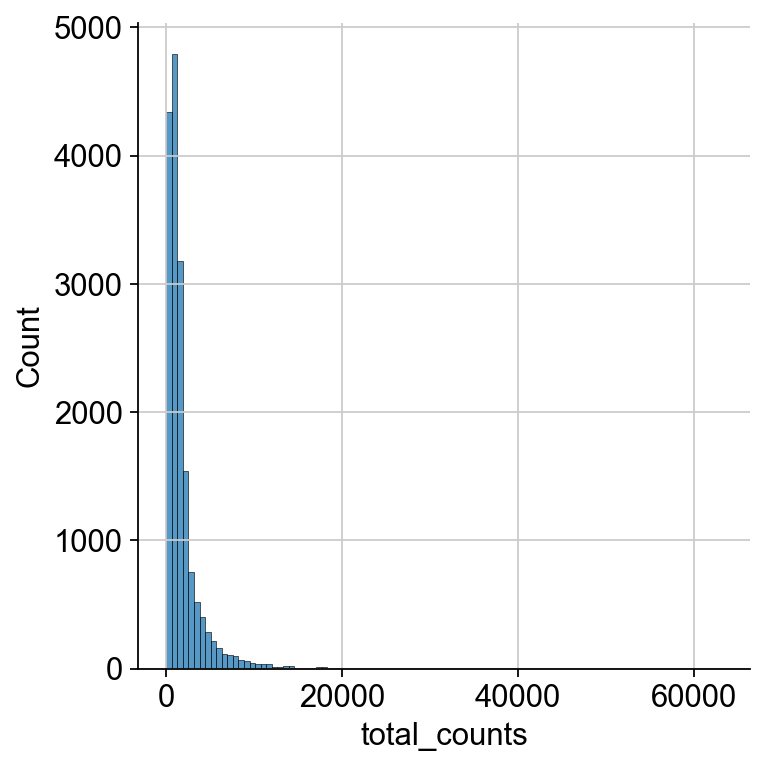

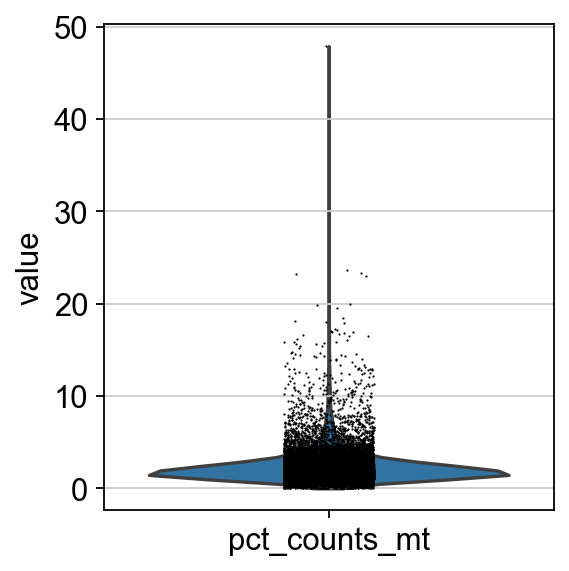

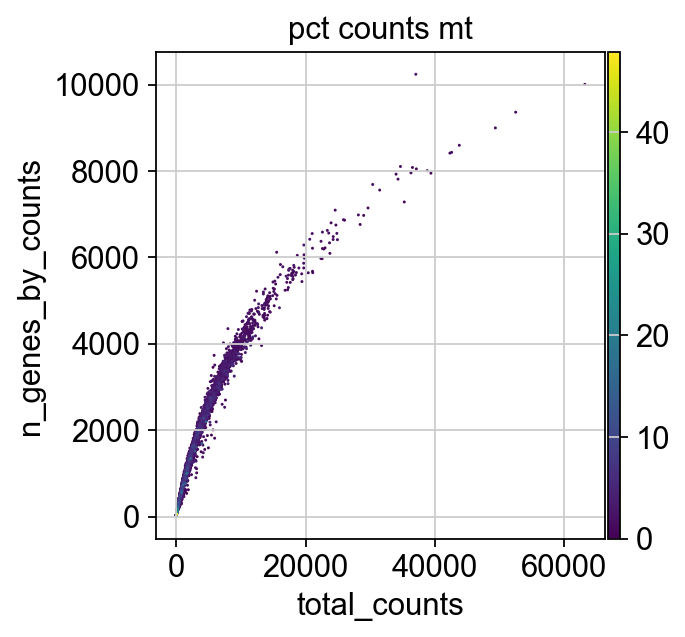

In [7]:
# Ditribution of barcodes (cells) in terms of the number of transcripts per barcode (cell)
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# To view above as a violon plot, try:
# sc.pl.violin(adata, 'total_counts')

# Distribution of barcodes (cells) in terms of the % mitochondrial transcripts per barcode (cell)
p2 = sc.pl.violin(adata, "pct_counts_mt")

# A scatter representing total_counts (x), n_genes_by_counts (y), and %mt of counts (color) per barcode (cell)
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Next, using metrics we calculated above, let us identify outliers in our dataset.  Below defines a function that checks if an observation is an outlier based on `nmads * MAD` (where MAD is median absolute deviation).  The output is a series of booleans.  
`MAD = median(|Xi-median(X)|)`

In [8]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

We want to tag as "outlier" those with counts that are more than 5 MADs from the median in the positive or negative direction (i.e., too far away from the median).  The metrics we look at are total counts (log-transformed), number of genes (log-transformed), and counts in the top 20 genes only (percent).  Below, `|` is a bitwise or operator comparing a 3 serieses of booleans (metrics).  If an observation (barcode) is an outlier in any of the three metrics, that barcode is tagged as an outlier.  We add this new information as a new column in our `adata.obs` dataframe, and we call that column `outlier`.

In [9]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    16065
True       869
Name: count, dtype: int64

We also apply the same function to identify outlier barcodes, based on the percent of mitochondrial transcripts.  We add this new information as a new column in our `adata.obs` dataframe, and we call that column `mt_outlier`.

In [10]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    15240
True      1694
Name: count, dtype: int64

Use outlier information to filter barcodes (cells).  Below, we use `~` which is a bitwise `not`, an inverse boolean mask (`True` to `False` and vice versa).

In [11]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 16934
Number of cells after filtering of low quality cells: 14814


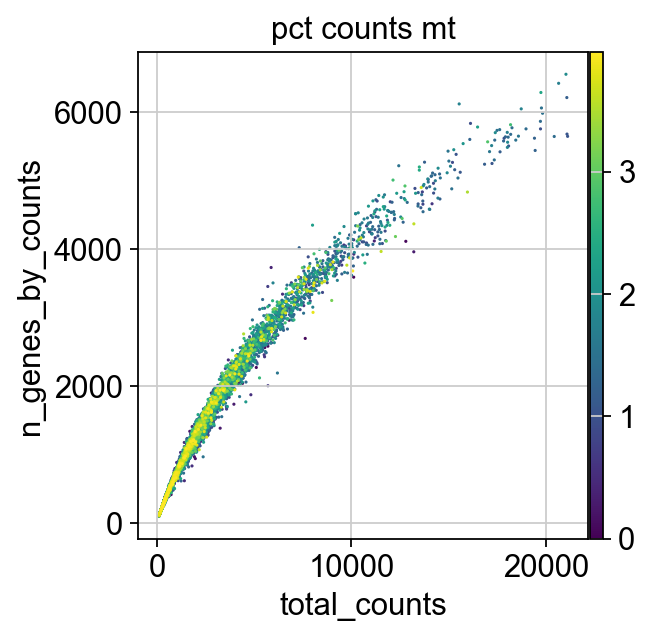

In [12]:
p4 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

We now have a smaller matrix (less barcodes).  We see that the ranges of the metrics are also now smaller.  

Save anndata to hda5, in case the Jupyter notebook kernel stops for any reason.

In [13]:
adata.write("../../training_data/s4d8_outliers_filtered_RNA.h5ad")

#### 2.2 Correction of ambient RNA  
This step attempts to remove or minimize the presence of free-floating or cell-free mRNA.  Here, we'll use R in between Python cells, and the packages `anndata2ri` and `rpy2` help us do that.

In [14]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'anndata2ri'

In [ ]:
%%R
library(SoupX)

In [ ]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)
adata_pp

In [ ]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")
adata_pp

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

In [ ]:
# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

In [ ]:
del adata_pp

In [ ]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [ ]:
adata_raw = sc.read_10x_h5(
    filename="../../training_data/raw_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/39546217",
)
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T

In [ ]:
del adata_raw

In [ ]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

In [ ]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

In [ ]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Note: Above count for number of genes is not the same as the book. 

In [ ]:
# Save above data, so as not to repeat all of above when kernel stops
adata.write("../../training_data/s4d8_corrected_ambient_RNA.h5ad")

#### 2.3 Doublet Detection  

In [ ]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

In [ ]:
data_mat = adata.X.T

In [ ]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

In [ ]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

In [ ]:
adata.write("../../training_data/s4d8_quality_control.h5ad")

### Note: Concatenating matrices from different batches

## 3. Normalization

In [ ]:
import scanpy as sc
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import anndata2ri
import logging
from scipy.sparse import issparse

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
adata = sc.read(
    filename="../../training_data/s4d8_quality_control.h5ad",
    backup_url="https://figshare.com/ndownloader/files/40014331",
)

In [ ]:
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

#### 3.1 Shifted logarithm

In [ ]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [ ]:
from scipy.sparse import csr_matrix, issparse

In [ ]:
%%R
library(scran)
library(BiocParallel)

In [ ]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

In [ ]:
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [ ]:
del adata_pp

In [ ]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [ ]:
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

In [ ]:
adata.write("../../training_data/s4d8_log1p_normalization.h5ad")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

#### 3.2 Analytic Pearson Residuals

In [ ]:
# Run this if kernel stops below
# adata = sc.read("../../training_data/s4d8_log1p_normalization.h5ad")

Cell below is memory-intensive

In [ ]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")
plt.show()

In [ ]:
adata.write("../../training_data/s4d8_normalization.h5ad")

## 4. Feature Selection

One of the commands below is memory-intensive (goes over the VM limit).  Export notebook with results to HTML first, then restart kernel before proceeding below. 

In [ ]:
import scanpy as sc
import anndata2ri
import logging
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
%%R
library(scry)

In [ ]:
adata = sc.read(
    filename="../../training_data/s4d8_normalization.h5ad",
    backup_url="https://figshare.com/ndownloader/files/40015741",
)

In [ ]:
ro.globalenv["adata"] = adata

In [ ]:
%%R
sce = devianceFeatureSelection(adata, assay="X")

In [ ]:
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

In [ ]:
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance

In [ ]:
sc.pp.highly_variable_genes(adata, layer="scran_normalization")

In [ ]:
ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

In [ ]:
adata.write("../../training_data/s4d8_feature_selection.h5ad")